In [5]:
from load_data.load_from_dropbox import dropbox_connect, download_and_save_all_files

if __name__ == "__main__":
    for sequence in ['flair', 't1', 't2']:
        dbx = dropbox_connect()
        folder_path = f'/severance_ax_npy/clear/{sequence}'
        local_dir = f'data/severance/{sequence}'
        download_and_save_all_files(dbx, folder_path, local_dir)

    dbx = dropbox_connect()
    folder_path = '/severance_ax_npy/motion/250305'
    local_dir = 'data/severance'
    download_and_save_all_files(dbx, folder_path, local_dir)

In [6]:
import os
import shutil

source_dir = 'data/severance'

def move_file_to_subfolder(file_path, folder_name):
    target_dir = os.path.join(source_dir, folder_name)
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    shutil.move(file_path, os.path.join(target_dir, os.path.basename(file_path)))

for item in os.listdir(source_dir):
    item_path = os.path.join(source_dir, item)
    
    if os.path.isfile(item_path):
        if "flair" in item:
            move_file_to_subfolder(item_path, "flair")
        elif "t1" in item:
            move_file_to_subfolder(item_path, "t1")
        elif "t2" in item:
            move_file_to_subfolder(item_path, "t2")

In [1]:
from load_data.data_io import load_data_dict

# flair : 276, t1 : 404, t2 : 552
for sequence in ['flair', 't1', 't2']:
    print(f'{sequence} data : ')
    severance_data = load_data_dict(f'severance/{sequence}')

flair data : 


276
t1 data : 
404
t2 data : 
552


In [6]:
import os
import numpy as np
from glob import glob
from collections import Counter

output_dir = 'data/severance'   
npy_files = glob(os.path.join(output_dir, '**', '*.npy'), recursive=True)

counter_shape0 = Counter()
counter_shape = Counter()

for npy_file in npy_files:
    data = np.load(npy_file)
    counter_shape0[data.shape[0]] += 1
    counter_shape[(data.shape[1], data.shape[2])] += 1

print("Counts for shape[0]:")
for key, count in sorted(counter_shape0.items()):
    print(f"{key}: {count}")

print("\nCounts for shape (H, W):")
for key, count in sorted(counter_shape.items()):
    print(f"{key}: {count}")


Counts for shape[0]:
3: 1
5: 1
6: 1
7: 1
8: 338
10: 628
12: 8
18: 1
20: 5
22: 1
24: 18
25: 1
26: 6
28: 9
30: 3
32: 9
34: 1
40: 1

Counts for shape (H, W):
(256, 256): 35
(288, 288): 1
(384, 312): 2
(448, 354): 1
(448, 360): 8
(512, 408): 9
(512, 512): 933
(528, 528): 7
(560, 560): 2
(640, 640): 6
(672, 672): 7
(768, 648): 6
(864, 864): 2
(1022, 1022): 1
(1024, 864): 3
(1024, 1024): 10


In [7]:
import os
import numpy as np
from glob import glob
from mri_processing import crop, minmax_normalization
import matplotlib.pyplot as plt

output_dir = 'data/severance_clear'
npy_files = glob(os.path.join(output_dir, '**', '*.npy'), recursive=True)

for npy_file in npy_files:
    data = minmax_normalization(np.load(npy_file))
    H, W = data.shape[1], data.shape[2]

    if H != W:
        crop_size = min(H, W)
        data = crop(data, crop_size)
        
    np.save(npy_file, data)

debug

In [15]:
import os
import csv
import numpy as np
from glob import glob

directory = 'data/severance_clear/'
csv_filename = 'output_clear.csv'

npy_files = glob(os.path.join(directory, '*.npy'))

with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["file_name", "slice_num", "score"])
    
    for npy_file in npy_files:
        file_name = os.path.basename(npy_file)
        data = np.load(npy_file)
        num_slices = data.shape[0]  
        
        for slice_idx in range(num_slices):
            writer.writerow([file_name, slice_idx+1, 50])

In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset
import warnings
import pandas as pd

warnings.simplefilter("ignore", UserWarning)

import pandas as pd
from sklearn.model_selection import train_test_split

class Test(Dataset):
    def __init__(self, cfg, subset='in'):
        self.image_dir = 'data/severance_clear/'
        self.df_test = pd.read_csv('output_clear.csv')

    def __getitem__(self, idx):
        sample = dict()

        slice_idx = self.df_test['slice_num'].iloc[idx] 
        img_name = self.image_dir + self.df_test['file_name'].iloc[idx]
        img_fr_iqm = self.df_test['score'].iloc[idx]

        img = torch.from_numpy(np.load(img_name)).float()[slice_idx-1]

        sample['img_path'] = img_name
        sample['img_fr_iqm'] = img_fr_iqm
        sample[f'img'] = img
        
        return sample

    def __len__(self):
        return len(self.df_test)

In [17]:
import os
import sys
import math

import numpy as np
import wandb
from einops import rearrange

import torch
from torch.utils.data import DataLoader
import torchvision

from network.network_utils import build_model
from network.optimizer_utils import get_optimizer, get_scheduler
from dataloaders import dataloader_gen

from utils.train_utils import Maxlloyd

from utils.test_utils import compute_score_v1

from utils.util import set_wandb, write_log
from collections import OrderedDict

def main(cfg):
    os.environ["CUDA_VISIBLE_DEVICES"] = cfg.gpu

    train_dataset, test_ref_loader, _ = dataloader_gen.gen_dataloader(cfg)

    train_dataset_scores = train_dataset.df[cfg.label_type].values
    cfg.n_scores = len(np.unique(train_dataset_scores))

    # pivot score setting
    maxlloyd = Maxlloyd(train_dataset_scores, rpt_num=cfg.spv_num)
    cfg.score_pivot_score = maxlloyd.get_new_rpt_scores()
    cfg.reference_point_num = len(cfg.score_pivot_score)

    net = build_model(cfg)

    if cfg.wandb:
        set_wandb(cfg)
        wandb.watch(net)

    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        net = net.cuda()

    optimizer = get_optimizer(cfg, net)
    lr_scheduler = get_scheduler(cfg, optimizer)

    checkpoint = torch.load('results/SRCC_Epoch_89_SRCC_0.9890_PCC_0.9938_MAE_0.6000.pth', map_location=torch.device("cuda:%s" % (0) if torch.cuda.is_available() else "cpu"))
    model_dict = net.state_dict()

    new_model_state_dict = OrderedDict()
    for k, v in model_dict.items():
        if k in checkpoint['model_state_dict'].keys():
            new_model_state_dict[k] = checkpoint['model_state_dict'][k]

        else:
            new_model_state_dict[k] = v
            print(f'Not Loaded\t{k}')
    net.load_state_dict(new_model_state_dict)

    test_dataset = Test(cfg=cfg)
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=cfg.num_workers, shuffle=False, pin_memory=True)

    if cfg.test_first:
        net.eval()
        f, c = evaluation(cfg, net, test_ref_loader, test_loader)    
    return f, c

def evaluation(cfg, net, ref_data_loader, data_loader):
    net.eval()
    test_fr_iqm_gt = data_loader.dataset.df_test['score'].values
    submission = data_loader.dataset.df_test[['file_name', 'slice_num']].copy()

    preds_list = []
    with torch.no_grad():
        with torch.autocast(device_type='cuda', dtype=torch.float16):

            # Extract features of auxiliary images
            f_list = []
            for idx, sample in enumerate(ref_data_loader):
                if idx % 1 == 0:
                    sys.stdout.write(f'\rExtract Aux Img Features... [{idx + 1}/{len(ref_data_loader)}]')
                
                image = sample[f'img'].cuda()
                image = image.unsqueeze(1)

                if image.shape[1] == 1:
                    image = image.repeat(1, 3, 1, 1)

                f = net('extraction', {'img': image})
                f_list.append(f)

            aux_f = torch.cat(f_list)
            aux_f = aux_f.squeeze()
            aux_f = aux_f.transpose(1, 0)

            # Extract features of test images
            test_f_list = []
            for idx, sample in enumerate(data_loader):

                if idx % 1 == 0:
                    sys.stdout.write(f'\rExtract Test Img Features... [{idx + 1}/{len(data_loader)}]')

                image = sample[f'img'].cuda()
                image = image.unsqueeze(1)

                if image.shape[1] == 1:
                    image = image.repeat(1, 3, 1, 1)

                f = net('extraction', {'img': image})
                f_hflip = net('extraction', {'img': torchvision.transforms.functional.hflip(image)})

                test_f_list.append(f)
                test_f_list.append(f_hflip)

            test_f = torch.cat(test_f_list)
            test_f = test_f.squeeze()
            test_f = rearrange(test_f, '(N Cr) C -> N Cr C', N=len(test_fr_iqm_gt), C=cfg.reduced_dim).mean(1)
            test_f = test_f.transpose(1, 0)

            # Set # of iterations
            n_iter = int(math.ceil(len(test_fr_iqm_gt) / cfg.test_batch_size))
            crop_num = 1
            start = 0

            features = []

            for idx in range(n_iter):
                if idx % 1 == 0:
                    sys.stdout.write(f'\rTesting... [{idx + 1}/{n_iter}]')

                batch = min(cfg.test_batch_size, len(test_fr_iqm_gt) - len(preds_list))

                f = torch.cat([aux_f.unsqueeze(0).repeat(batch, 1, 1),
                               rearrange(test_f[:, start:start + (batch * crop_num)], 'C (N L) -> N C L', N=batch, L=crop_num)], dim=-1)

                # Obtain updated features and score pivots
                f, score_pivots = net('get_cluster', {'f': f})
                features.append(f)

                # Estimate quality scores
                preds = compute_score_v1(embs=rearrange(f, 'b c l -> b l c')[:, -1:],
                                         spv=rearrange(score_pivots, 'b c l -> b l c'),
                                         emb_scores=torch.tensor(test_fr_iqm_gt[start:(start + batch)].reshape(-1, 1)).cuda().float(),
                                         spv_scores=cfg.score_pivot_score,
                                         )

                preds_list.extend(preds.tolist())
                start += (batch * crop_num)

    features = torch.cat(features)
    features = features.squeeze()

    preds_np = np.array(preds_list)

    submission['score'] = preds_np  

    submission.to_csv('results/submission.csv', index=False)

    return features, preds_np

if __name__ == "__main__":
    from configs.config_v1 import ConfigV1 as Config

    cfg = Config()
    cfg.exclude = False
    features, labels = main(cfg)

Q eror | Init R: 0.18870 | New R: 0.00000


Testing... [4/214]eatures... [2140/2140]

/root/IQM-MR/network/ct.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
/root/IQM-MR/network/ct.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


Testing... [214/214]

In [18]:
print(features.shape)
print(labels.min(), labels.max())
features = features.view(features.size(0), -1)
features = features.cpu().numpy()

torch.Size([2140, 256, 18])
43.4493293762207 50.96979904174805


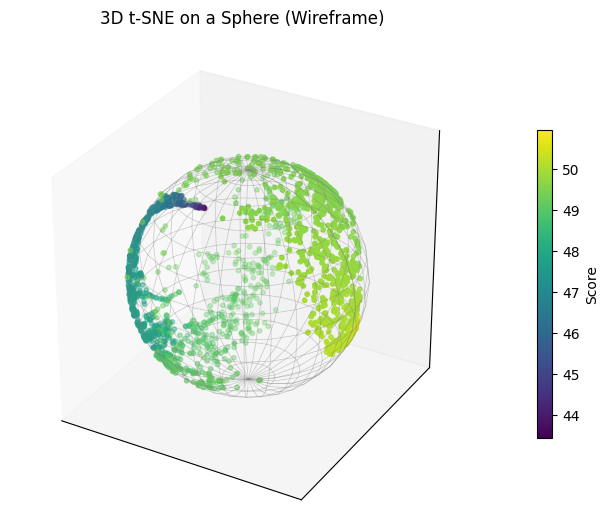

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, random_state=42)
features_3d = tsne.fit_transform(features)

norms = np.linalg.norm(features_3d, axis=1, keepdims=True)
features_on_sphere = features_3d / norms

u = np.linspace(0, 2*np.pi, 30)
v = np.linspace(0, np.pi, 15)
x = np.outer(np.cos(u), np.sin(v))  
y = np.outer(np.sin(u), np.sin(v))  
z = np.outer(np.ones_like(u), np.cos(v))  

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x, y, z, color='gray', linewidth=0.5, alpha=0.4)

scatter = ax.scatter(features_on_sphere[:, 0],
                     features_on_sphere[:, 1],
                     features_on_sphere[:, 2],
                     c=labels,        
                     cmap='viridis',  
                     s=10)           

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect((1, 1, 1))  

ax.set_title("3D t-SNE on a Sphere (Wireframe)", pad=20)

cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, pad=0.1)
cbar.set_label('Score')

plt.show()

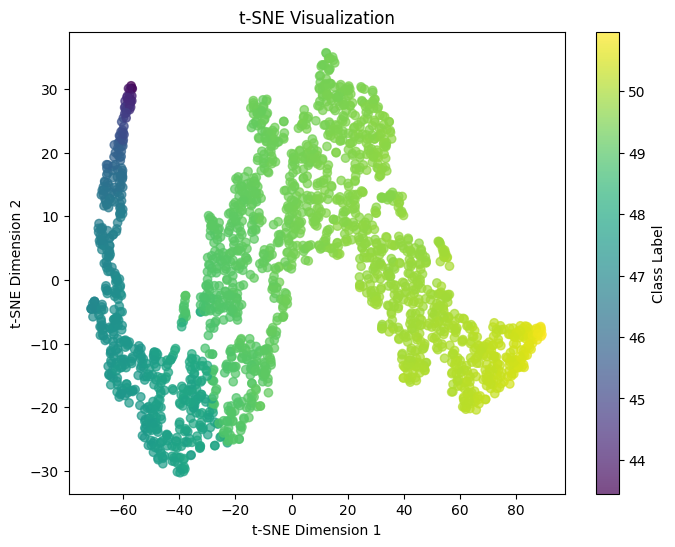

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter, label='Class Label')
plt.show()

In [ ]:
import os
import numpy as np

import torch
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt

from dataloaders import dataloader_gen

from configs.config_v1 import ConfigV1 as Config
cfg = Config()
os.environ["CUDA_VISIBLE_DEVICES"] = cfg.gpu

if cfg.exclude:
    train_dataset, test_ref_loader_in, testㄴ_loader_in, test_ref_loader_ex, test_loader_ex = dataloader_gen.gen_dataloader(cfg)
else:
    train_dataset, test_ref_loader, test_loader = dataloader_gen.gen_dataloader(cfg)

if cfg.dataset_name == 'Simulation':
    train_dataset_scores = train_dataset.df[cfg.label_type].values
elif cfg.dataset_name == 'Severance':
    train_dataset_scores = train_dataset.df['label'].values
cfg.n_scores = len(np.unique(train_dataset_scores))

train_dataset.get_pair_lists(batch_size=cfg.batch_size, batch_list_len=cfg.im_list_len, im_num=cfg.im_num, uniform_select=False)
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=cfg.num_workers, shuffle=False, pin_memory=True, drop_last=True)

dataloader_iterator = iter(train_loader)
print(len(dataloader_iterator))

for idx in range(len(dataloader_iterator) // cfg.batch_size):
    scores = []
    groups = []
    for dl_iter in range(cfg.batch_size):
        sample = next(dataloader_iterator)

        scores_tmp = torch.cat([sample[f'img_{im_idx}_label'] for im_idx in range(cfg.im_num)])
        scores_tmp = scores_tmp.cuda().float()
        scores.append(scores_tmp)

        groups_tmp = torch.cat([sample[f'img_{im_idx}_group'] for im_idx in range(cfg.im_num)])
        groups_tmp = groups_tmp.cuda()
        groups.append(groups_tmp)
        if idx < 20:
            for im_idx in range(cfg.im_num):
                img = sample[f'img_{im_idx}'].cuda()
                plt.imshow(img[0].cpu().numpy(), cmap='gray')
                plt.axis('off')
                plt.title(f'Image {scores_tmp[im_idx], groups_tmp[im_idx]}')
                plt.show()
        else:
            break